In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
# load data
dt_train_raw = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/raw/train.csv")
dt_test_raw = pd.read_csv("../../data/Mercedes_Benz_Greener_Manufacturing/raw/test.csv")

In [3]:
# outlier
dt_outlier = dt_train_raw.loc[dt_train_raw.y == max(dt_train_raw.y.values)]
dt_outlier

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
883,1770,265.32,y,r,ai,f,d,ag,l,t,...,0,0,0,0,0,0,0,0,0,0


**X, y, ID**

In [4]:
# remove outlier
dt_train_raw_no_outlier = dt_train_raw.loc[dt_train_raw["ID"] != dt_outlier["ID"].values[0]]

In [5]:
X = dt_train_raw_no_outlier.drop(["ID", "y"], axis = 1)
y = dt_train_raw_no_outlier.y.values
ID = dt_train_raw_no_outlier.ID.values

In [6]:
X.shape

(4208, 376)

**One-hot Encoding**

In [7]:
# cols_cat
cols_cat = X.select_dtypes(include = ['object']).columns.values
dt_cat_onehot = pd.get_dummies(X[cols_cat])
X = X.drop(cols_cat, axis = 1)
X = X.join(dt_cat_onehot)

In [8]:
X.shape

(4208, 563)

**ExtraTree**

In [34]:
# extratree
params = {
    "n_jobs": 7
    , "n_estimators": 400
    , "max_depth": 3
    , "min_samples_split": 5
    , "random_state": 888
    , "verbose": 0
}
model_extra = ExtraTreesRegressor(**params)

**Random Split**

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 888)

In [11]:
model_extra.fit(X_train, y_train)
preds_valid = model_extra.predict(X_valid)
r2_score(y_valid, preds_valid)

0.52565801661607581

**K Fold**

In [16]:
# stratified kfold
kf = KFold(n_splits = 5, shuffle = True, random_state = 888)

In [35]:
for ind_train, ind_valid in kf.split(X):
    # X, y
    X_train, X_valid = X.iloc[ind_train], X.iloc[ind_valid]
    y_train, y_valid = y[ind_train], y[ind_valid]
    
    # model
    model_extra.fit(X_train, y_train)
    
    # pred
    preds_train = model_extra.predict(X_train)
    preds_valid = model_extra.predict(X_valid)
    
    # score
    score_train = r2_score(y_train, preds_train)
    score_valid = r2_score(y_valid, preds_valid)
    
    print("R^2 on Train: ", score_train, "R^2 on Valid: ", score_valid)

R^2 on Train:  0.602535475808 R^2 on Valid:  0.559855696006
R^2 on Train:  0.612433946519 R^2 on Valid:  0.538886648967
R^2 on Train:  0.59829331832 R^2 on Valid:  0.599107291029
R^2 on Train:  0.589047292434 R^2 on Valid:  0.615433343798
R^2 on Train:  0.60142744751 R^2 on Valid:  0.583408754974


**Stratified Kfold**

In [24]:
# bin y
bin_y = pd.cut(y, 5, labels = [1, 2, 3, 4, 5]).astype("int64")

In [26]:
# stratified kfold
gkf = GroupKFold(n_splits = 5)

In [27]:
for ind_train, ind_valid in gkf.split(X, y, groups = bin_y):
    # X, y
    X_train, X_valid = X.iloc[ind_train], X.iloc[ind_valid]
    y_train, y_valid = y[ind_train], y[ind_valid]
    
    print("X_train: ", X_train.shape, "X_valid: ", X_valid.shape)
    # model
    model_extra.fit(X_train, y_train)
    # pred
    preds_valid = model_extra.predict(X_valid)
    # score
    score = r2_score(y_valid, preds_valid)
    print("R^2: ", score)

X_train:  (1984, 563) X_valid:  (2224, 563)
R^2:  -3.73698969767
X_train:  (2981, 563) X_valid:  (1227, 563)
R^2:  -9.55055240255
X_train:  (3530, 563) X_valid:  (678, 563)
R^2:  -7.23753408018
X_train:  (4143, 563) X_valid:  (65, 563)
R^2:  -36.3613184809
X_train:  (4194, 563) X_valid:  (14, 563)
R^2:  -71.282780992


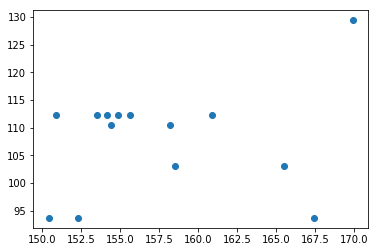

In [28]:
plt.scatter(y_valid, preds_valid)
plt.show()

In [ ]:
# group kfold